<div><div style="float:left; clear:both;"><img src="img/colab.png" align="left" width="200" height="200" /><br></div><div style="float:left; clear:both;"><a href="https://colab.research.google.com/drive/1ahHDNPMOHIMI1K1NdSqSXNal13XXSrHi">Abre este Jupyter en Google Colab</a></div></div>

# Caso práctico: _Principal Component Analysis_ (PCA)

En este caso de uso práctico se presenta un mecanismo de extracción de características (reducción de dimensionalidad) mediante el uso del algoritmo PCA.

## Conjunto de datos: Detección de malware en Android

### Descripción
The sophisticated and advanced Android malware is able to identify the presence of the emulator used by the malware analyst and in response, alter its behavior to evade detection. To overcome this issue, we installed the Android applications on the real device and captured its network traffic. See our publicly available Android Sandbox.

CICAAGM dataset is captured by installing the Android apps on the real smartphones semi-automated. The dataset is generated from 1900 applications with the following three categories:

**1. Adware (250 apps)**
* Airpush: Designed to deliver unsolicited advertisements to the user’s systems for information stealing.
* Dowgin: Designed as an advertisement library that can also steal the user’s information.
* Kemoge: Designed to take over a user’s Android device. This adware is a hybrid of botnet and disguises itself as popular apps via repackaging.
* Mobidash: Designed to display ads and to compromise user’s personal information.
* Shuanet: Similar to Kemoge, Shuanet also is designed to take over a user’s device.

**2. General Malware (150 apps)**
* AVpass: Designed to be distributed in the guise of a Clock app.
* FakeAV: Designed as a scam that tricks user to purchase a full version of the software in order to re-mediate non-existing infections.
* FakeFlash/FakePlayer: Designed as a fake Flash app in order to direct users to a website (after successfully installed).
* GGtracker: Designed for SMS fraud (sends SMS messages to a premium-rate number) and information stealing.
* Penetho: Designed as a fake service (hacktool for Android devices that can be used to crack the WiFi password). The malware is also able to infect the user’s computer via infected email attachment, fake updates, external media and infected documents.

**3. Benign (1500 apps)**
* 2015 GooglePlay market (top free popular and top free new)
* 2016 GooglePlay market (top free popular and top free new)

### Ficheros de datos
* pcap files – the network traffic of both the malware and benign (20% malware and 80% benign)
* <span style="color:green">.csv files - the list of extracted network traffic features generated by the CIC-flowmeter</span>

### Descarga de los ficheros de datos
https://www.unb.ca/cic/datasets/android-adware.html

### Referencias adicionales sobre el conjunto de datos
_Arash Habibi Lashkari, Andi Fitriah A. Kadir, Hugo Gonzalez, Kenneth Fon Mbah and Ali A. Ghorbani, “Towards a Network-Based Framework for Android Malware Detection and Characterization”, In the proceeding of the 15th International Conference on Privacy, Security and Trust, PST, Calgary, Canada, 2017._

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

## Funciones auxiliares

In [2]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

## 1. Lectura del conjunto de datos

In [4]:
df = pd.read_csv('datasets/TotalFeatures-ISCXFlowMeter.csv')

## 2. Visualización del conjunto de datos

In [5]:
df.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
0,1020586,668,1641,35692,2276876,52,52,679,1390,53.431138,...,0.0,-1,0.0,2,4194240,1853440,1640,668,32,benign
1,80794,1,1,75,124,75,124,75,124,75.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
2,998,3,0,187,0,52,-1,83,-1,62.333333,...,0.0,-1,0.0,4,101888,-1,0,3,32,benign
3,189868,9,9,1448,6200,52,52,706,1390,160.888889,...,0.0,-1,0.0,2,4194240,2722560,8,9,32,benign
4,110577,4,6,528,1422,52,52,331,1005,132.000000,...,0.0,-1,0.0,2,155136,31232,5,4,32,benign
5,261876,7,6,1618,882,52,52,730,477,231.142857,...,0.0,-1,0.0,2,4194240,926720,3,7,32,benign
6,14,2,0,104,0,52,-1,52,-1,52.000000,...,0.0,-1,0.0,3,5824,-1,0,2,32,benign
7,29675,1,1,71,213,71,213,71,213,71.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
8,806635,4,0,239,0,52,-1,83,-1,59.750000,...,0.0,-1,0.0,5,107008,-1,0,4,32,benign
9,56620,3,2,1074,719,52,52,592,667,358.000000,...,0.0,-1,0.0,3,128512,10816,1,3,32,benign


In [6]:
df.describe()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,6.319550e+05,631955.000000,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.000000,631955.000000,631955.000000,631955.000000,...,6.319550e+05,6.319550e+05,6.319550e+05,6.319550e+05,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.00000,631955.000000
mean,2.195245e+07,6.728514,10.431934,9.540172e+02,1.206042e+04,141.475727,44.357688,263.675901,183.248084,174.959706,...,1.997327e+07,2.031228e+07,2.075238e+07,4.663875e+05,2.360896,9.620796e+05,3.104519e+05,9.733144,6.72471,19.965713
std,1.900578e+08,174.161354,349.424019,8.235040e+04,4.824716e+05,157.680880,89.099554,289.644383,371.863224,162.024811,...,1.897986e+08,1.897902e+08,1.899721e+08,6.199704e+06,3.041810,1.705655e+06,6.647956e+05,347.877923,174.13813,14.914261
min,-1.800000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,-1.000000e+00,-1.000000e+00,0.000000,0.00000,0.000000
25%,0.000000e+00,1.000000,0.000000,6.900000e+01,0.000000e+00,52.000000,-1.000000,52.000000,-1.000000,52.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,0.000000e+00,-1.000000e+00,0.000000,1.00000,0.000000
50%,2.445000e+04,1.000000,0.000000,1.840000e+02,0.000000e+00,52.000000,-1.000000,83.000000,-1.000000,83.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,8.761600e+04,-1.000000e+00,0.000000,1.00000,32.000000
75%,1.759751e+06,3.000000,1.000000,4.270000e+02,1.670000e+02,108.000000,52.000000,421.000000,115.000000,356.000000,...,1.013498e+06,1.291379e+06,1.306116e+06,0.000000e+00,2.000000,3.046400e+05,9.049600e+04,1.000000,3.00000,32.000000
max,4.431076e+10,48255.000000,74768.000000,4.049644e+07,1.039222e+08,1390.000000,1390.000000,1500.000000,1390.000000,1390.000000,...,4.431072e+10,4.430000e+10,4.431072e+10,8.470000e+08,2269.000000,4.194240e+06,4.194240e+06,74524.000000,48255.00000,44.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631955 entries, 0 to 631954
Data columns (total 80 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration                 631955 non-null  int64  
 1   total_fpackets           631955 non-null  int64  
 2   total_bpackets           631955 non-null  int64  
 3   total_fpktl              631955 non-null  int64  
 4   total_bpktl              631955 non-null  int64  
 5   min_fpktl                631955 non-null  int64  
 6   min_bpktl                631955 non-null  int64  
 7   max_fpktl                631955 non-null  int64  
 8   max_bpktl                631955 non-null  int64  
 9   mean_fpktl               631955 non-null  float64
 10  mean_bpktl               631955 non-null  float64
 11  std_fpktl                631955 non-null  float64
 12  std_bpktl                631955 non-null  float64
 13  total_fiat               631955 non-null  int64  
 14  tota

In [8]:
df['calss'].value_counts()

benign            471597
asware            155613
GeneralMalware      4745
Name: calss, dtype: int64

## 3. Extracción de características: PCA

In [9]:
# Separamos las variables de entrada (X) de la etiqueta (y)
# Transformamos y a valor numérico
X_df, y_df = remove_labels(df, 'calss')
y_df = y_df.factorize()[0]

La extracción de características es una técnica muy útil para representar un conjunto de datos multidimensional y ganar intuiciones sobre los límites de decisión que construye un algoritmo. Para ello podemos utilizar el algoritmo PCA y reducir el numero de características a 2.

In [10]:
# Reducimos el conjunto de datos a 2 dimensiones utilizando el algoritmo PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_reduced = pca.fit_transform(X_df)

In [11]:
df_reduced = pd.DataFrame(df_reduced, columns=["c1", "c2"])

In [12]:
df_reduced.head(10)

,c1,c2
0,-6.653632e+07,-9.564604e+06
1,-6.704580e+07,-9.898031e+06
2,-6.712784e+07,-9.875840e+06
3,-6.699982e+07,-9.782837e+06
4,-6.702599e+07,-9.829385e+06
5,-6.691581e+07,-9.791010e+06
6,-6.713106e+07,-9.880533e+06
7,-6.709856e+07,-9.884049e+06
8,-6.610628e+07,-9.807246e+06
9,-6.705952e+07,-9.848264e+06


**Representamos el nuevo conjunto de datos con dos características de entrada y tres categorías (y)**

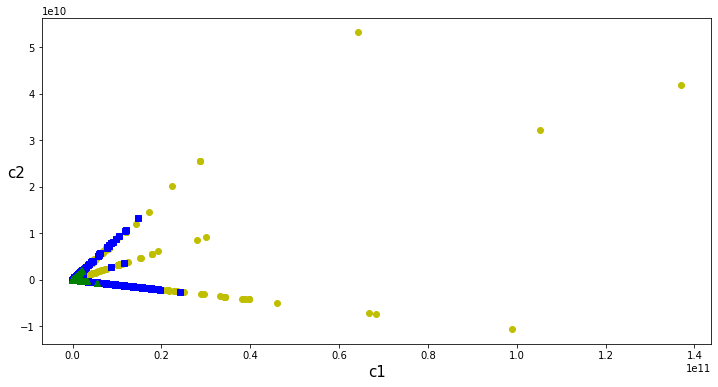

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 6))
plt.plot(df_reduced["c1"][y_df==0], df_reduced["c2"][y_df==0], "yo", label="normal")
plt.plot(df_reduced["c1"][y_df==1], df_reduced["c2"][y_df==1], "bs", label="adware")
plt.plot(df_reduced["c1"][y_df==2], df_reduced["c2"][y_df==2], "g^", label="malware")
plt.xlabel("c1", fontsize=15)
plt.ylabel("c2", fontsize=15, rotation=0)
plt.show()

In [14]:
# Calculamos la proporción de varianza que se ha preservado del conjunto original
pca.explained_variance_ratio_

array([0.91695209, 0.05610877])

El resultado anterior nos indica que el 91,6% de la varianza del conjunto de datos original se mantiene en el primer eje, y el 5,6% en el segundo eje. Esto quiere decir que aproximadamente 2,8% de la varianza se mantiene en el resto de ejes que no se han utilizado para construir el nuevo conjunto, por lo tanto, es razonable pensar que el resto de características del conjunto de datos no aportaban demasiada información.

**Representamos el límite de decisión que generaría un algoritmo en este nuevo conjunto de datos reducido**

In [15]:
# Generamos un modelo con el conjunto de datos reducido
from sklearn.tree import DecisionTreeClassifier

clf_tree_reduced = DecisionTreeClassifier(max_depth=3, random_state=42)
clf_tree_reduced.fit(df_reduced, y_df)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

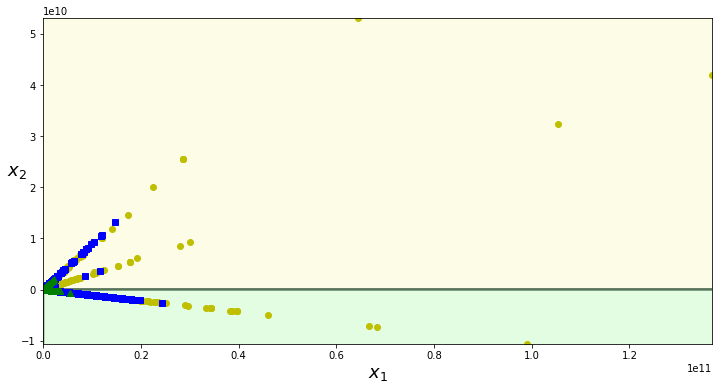

In [16]:
# Representamos el límite de decisión generado por el modelo
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, plot_training=True, resolution=1000):
    mins = X.min(axis=0) - 1
    maxs = X.max(axis=0) + 1
    x1, x2 = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="normal")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="adware")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="malware")
        plt.axis([mins[0], maxs[0], mins[1], maxs[1]])               
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

plt.figure(figsize=(12, 6))
plot_decision_boundary(clf_tree_reduced, df_reduced.values, y_df)
plt.show()

Si nuestro objetivo no es visualizar el conjunto de datos, sino reducir la dimensionalidad del conjunto de datos original, en lugar de seleccionar arbitrariamente el numero de dimensiones, sklearn nos proporciona un mecanismo para seleccionar aquellas dimensiones que mantienen un determinado porcetaje de varianza.

In [17]:
# Reducimos el conjunto de datos manteniendo el 99,9% de varianza
from sklearn.decomposition import PCA

pca = PCA(n_components=0.999)
df_reduced = pca.fit_transform(X_df)

In [18]:
# Numero de dimensionaes del nuevo conjunto
print("Número de componentes:", pca.n_components_)

Número de componentes: 6


In [19]:
# Calculamos la proporción de varianza que se ha preservado del conjunto original
pca.explained_variance_ratio_

array([9.16952089e-01, 5.61087653e-02, 2.16566915e-02, 3.65011318e-03,
       5.56686331e-04, 3.79356201e-04])

In [20]:
# Transformamos a un DataFrame de Pandas
df_reduced = pd.DataFrame(df_reduced, columns=["c1", "c2", "c3", "c4", "c5", "c6"])
df_reduced["Class"] = y_df
df_reduced

,c1,c2,c3,c4,c5,c6,Class
0,-6.653632e+07,-9.564604e+06,3.437284e+06,-2.949219e+06,1.822415e+06,-1.049114e+06,0
1,-6.704580e+07,-9.898031e+06,3.424601e+06,-3.127607e+06,2.800781e+06,-1.063954e+06,0
2,-6.712784e+07,-9.875840e+06,3.461085e+06,-3.118886e+06,2.823975e+06,-1.022121e+06,0
3,-6.699982e+07,-9.782837e+06,3.436564e+06,-3.051254e+06,2.557188e+06,-9.126112e+05,0
4,-6.702599e+07,-9.829385e+06,3.484764e+06,-3.108501e+06,2.726738e+06,-1.074407e+06,0
...,...,...,...,...,...,...,...
631950,-6.712883e+07,-9.876545e+06,3.460169e+06,-3.121068e+06,2.841346e+06,-1.034425e+06,0
631951,-1.490810e+07,1.783457e+07,3.127773e+06,7.128419e+06,-3.846691e+07,-8.013578e+06,2
631952,2.098170e+07,6.844411e+07,-3.376382e+07,-2.849601e+07,2.306222e+06,-3.567339e+05,1
631953,1.163357e+07,3.237585e+07,5.077168e+06,1.323917e+07,-5.531286e+07,-1.294719e+07,0


## 4. División del conjunto de datos

In [21]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df_reduced)

In [22]:
X_train, y_train = remove_labels(train_set, 'Class')
X_val, y_val = remove_labels(val_set, 'Class')
X_test, y_test = remove_labels(test_set, 'Class')

## 5. Random Forests

In [23]:
from sklearn.ensemble import RandomForestClassifier

clf_rnd = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [24]:
# Predecimos con el conjunto de datos de validación
y_val_pred = clf_rnd.predict(X_val)

In [25]:
# F1 score conjunto de datos de validación
print("F1 score validation test:", f1_score(y_val_pred, y_val, average='weighted'))

F1 score validation test: 0.8914140064148489


In [26]:
# Predecimos con el conjunto de datos de pruebas
y_test_pred = clf_rnd.predict(X_test)

In [27]:
# F1 score conjunto de datos de pruebas
print("F1 score test set:", f1_score(y_test_pred, y_test, average='weighted'))

F1 score test set: 0.8945365648002198
